# Visualizing Simulation Results
                                 Authors = {'Matt Adam-Houser':'https://github.com/mhouser42',
                                            'Justin Tung': 'https://github.com/JayTongue'}


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import pickle
import networkx as nx
import ipywidgets
from ipywidgets import widgets

from run_simulation import infestation_main  # Custom function from run_simulation.py

---------------------------------
----------------------------------
# 1. Running and Visualizing One Simulation

Sample output from one simulation of the infestation code:

In [2]:
years_run = 15
run_mode = 'Baseline'
simulation_df = infestation_main(run_mode, years_run) # Change this to change the number of years
simulation_df

,County,month 0,month 1,month 2,month 3,month 4,month 5,month 6,month 7,month 8,month 9,month 10,month 11,month 12,month 13,month 14,month 15
0,Cook,0.3,3.288301e-01,0.427318,0.577145,0.992499,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0000
1,DuPage,0.0,4.242866e-02,0.066452,0.184925,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0000
2,Kane,0.1,1.625128e-01,0.211207,0.365695,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0000
3,Will,0.0,4.650248e-02,0.000000,0.147828,0.777183,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0000
4,Winnebago,0.0,0.000000e+00,0.000000,0.000060,0.000000,0.863806,1.000000,1.000000,0.694445,1.000000,1.000000,1.000000,1.000000,0.951972,1.0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Henderson,0.0,1.392135e-02,0.235716,0.389572,0.997220,1.000000,0.854356,0.739362,0.607186,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0000
98,Calhoun,0.0,5.700000e-07,0.000002,0.000027,0.000059,0.004353,0.017041,0.054055,0.075760,0.109492,0.322358,0.688419,0.573898,1.000000,1.0,0.9309
99,Schuyler,0.0,1.398000e-05,0.000230,0.000000,0.017261,0.170279,0.261109,0.285651,0.581188,0.685307,0.951827,1.000000,1.000000,1.000000,1.0,1.0000
100,Gallatin,0.0,3.492890e-03,0.100299,0.171219,0.512570,0.931605,1.000000,1.000000,0.840399,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0000


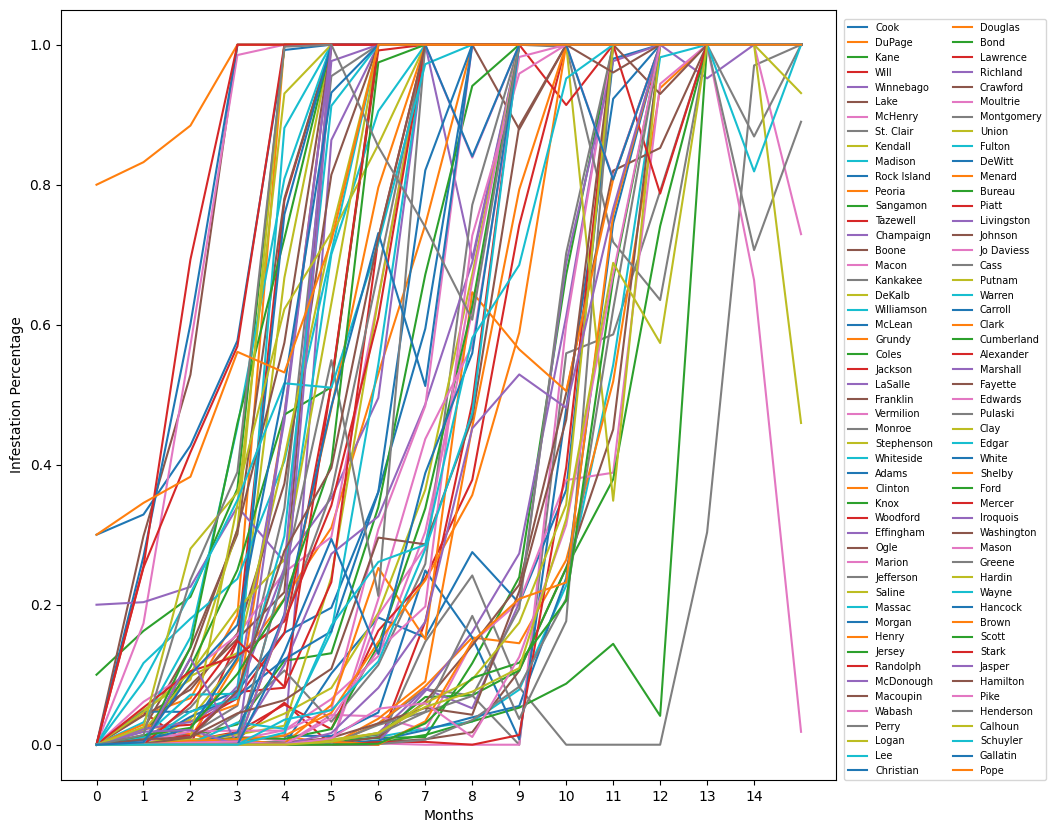

In [3]:
def make_visual_df(simulation_df: pd.DataFrame) -> pd.DataFrame:
    """
    Utility function.
    rotates the run_simulation output df to help with some visualizations
    :param simulation_df:
    :return visual_df:
    """
    visual_df = simulation_df.T
    visual_df.columns = visual_df.iloc[0]
    visual_df = visual_df.drop(visual_df.index[0])
    return visual_df

visual_df = make_visual_df(simulation_df)

# Make plots for each county
plt.figure(figsize=(10,10))
for county in visual_df.columns:
    plt.plot(visual_df.index, visual_df[county])
plt.xticks(ticks=range(0, 15),
    labels=range(0, 15))
plt.xlabel('years')
plt.ylabel('Infestation Percentage')
plt.legend(visual_df.columns, loc=(1.01, 0), fontsize=7, ncol=2)
plt.show()

This graph is not very helpful. Since there are 102 Counties in Illinois, the resulting graph is messy and visually confusing. 

An alternative way of visualizing this data may be with a sort of heatmap instead

In [4]:
path = 'data/location'
edges = pd.read_csv(f'{path}/county_edges.csv')

CG = pickle.load(open(f'{path}/IL_graph.dat', 'rb'))
handler = pickle.load(open(f'{path}/graph_handler_counties.dat', 'rb'))
highways = pickle.load(open(f'{path}/osmnx_highways.dat', 'rb'))

In [5]:
def make_network_heat(year: int):
    """
    Makes a heatmap from the NX nodes, edges, and object instances
    :param year: The number of years from the interactive ipywidget
    """
    year = f'year {year}'
#     min_value = simulation_df[year].min()
#     max_value = simulation_df[year].max()  # This makes the scale variable for each chart
    max_value = 1  # This keeps the scale constant 
    min_value = 0
    cmap = matplotlib.colormaps['YlOrRd']

    node_colors = {}
    for node in CG.nodes():
        value = simulation_df.loc[simulation_df['County'] == node.name, year].iloc[0]
        normalized_value = (value - min_value) / (max_value - min_value)
        node_colors[node.name] = cmap(normalized_value)
        
    labels = {node: handler[node.name].name for node in CG.nodes()}
    fig, ax = plt.subplots(figsize=(10, 15))
    node_positions = {node: [node.centroid.x, node.centroid.y] for node in CG.nodes()}
    nx.draw(CG, 
            pos=node_positions,
            ax=ax, 
            node_color=[node_colors.get(node.name, 'gray') for node in CG.nodes()],
            node_size=1500, )

    nx.draw_networkx_labels(CG, 
                            pos=node_positions, 
                            labels=labels,
                            font_size=6, 
                            ax=ax,
                           font_color='k')
    
    edge_colors = ['gray' if CG[src][tgt]['rel'] == 'interstate' else 'gray' for src, tgt in CG.edges()]
    edge_widths = [5 if CG[src][tgt]['rel'] == 'interstate' else 1 for src, tgt in CG.edges()]
    nx.draw_networkx_edges(CG, pos=node_positions, edge_color=edge_colors, ax=ax, width=edge_widths)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_value, vmax=max_value))
    sm.set_array([])
    sub_ax = plt.axes([0.96, 0.55, 0.02, 0.3])
    plt.colorbar(sm, cax=sub_ax)
    plt.show()

In [6]:
widgets.interact(make_network_heat,
    year=widgets.IntSlider(min=0, max=len(simulation_df.columns)-2, step=1, layout=widgets.Layout(width='800px')),
)

interactive(children=(IntSlider(value=0, description='month', layout=Layout(width='800px'), max=15), Output())…

<function __main__.make_network_heat(month: int)>

In order to better see the flow of infestations from week to week, we animated the slider:

In [ ]:
play = widgets.interact(make_network_heat,
    year=widgets.Play(value=0,
                        min=0,
                        max=len(simulation_df.columns) - 2,
                        step=1,
                        interval=1000,
                        disabled=False,
                    ))

Showing the infestation of the state as a whole is more helpful than each individual county:

In [ ]:
avg_df = visual_df.mean(axis=1)
plt.figure(figsize=(12,8))
plt.plot(avg_df.index, avg_df.iloc[0:, ])
plt.tick_params(labelsize=8)

--------------------------------
# 2. Running Repeated Simulations

With this line graph, we can run the simulation as many times as desired and compare the results.

In [ ]:
def make_average_graphs(df: pd.DataFrame, sim_years: int):
    """
    Takes the average values over the whole state for each given simulation df.
    Plots them all within the same graph
    :param df:
    :param sim_years:
    """
    vis_df = make_visual_df(df)
    avg_df = vis_df.mean(axis=1)
    plt.xticks(ticks=range(0, sim_years+1),
               labels=range(0, sim_years+1))
    plt.xlabel('years')
    plt.ylabel('Infestation Percentage')
    plt.plot(avg_df.index, avg_df, linewidth=0.5)
    
def model_variables(run_mode: str, sims_run: int, sim_years: int):
    """
    Loops through the number of simulations run
    Passes the resulting df to make_average_graphs()
    shows the plot at the end
    :param run_mode:
    :param sims_run:
    :param sim_years:
    """
    plt.figure(figsize=(12,8))
    plt.tick_params(labelsize=8)
    plt.grid()
    
    for i in range(0, sims_run):
        df = infestation_main(run_mode, sim_years)
        make_average_graphs(df, sim_years)  # hopefully putting this inside the loop will allow the code to forget the df
    
    plt.show()

This interactive graph shows different run modes, different experiment durations, and different numbers of simulations.

In [ ]:
widgets.interact(model_variables,
    run_mode =['Baseline', 'Poison ToH', 'Population-Based Countermeasures', 'Quarantine'],
    sims_run = (10, 100, 10),
    sim_years = (1, 30, 1),
    value='Baseline',
    disabled=False,

)

------------------------------------------------
# 3. Model the Impact of a Experimental Variable Manipulation

After running multiple simulations on each model, the resulting average trend lines can be determined for each experimental varaible.

Note that these simulations are extended to 30 monthyears to show longer-term trends.

In [ ]:
sims_run = 20  # RIP my RAM
sim_years = 40

all_trends = {}
def model_variables_avg(run_mode: str, sims_run: int, sim_years: int, all_trends: dict) -> dict:
    """
    A modified version of model_variables
    includes an trend line that averages all the simulations graphed
    Average line is made with the all_trends dict to get passed to the next block of simulations
    :param run_mode:
    :param sims_run:
    :param sim_years:
    :param all_trends:
    :return all_trends:
    """
    plt.figure(figsize=(12, 8))
    plt.title(f'{run_mode} Infestation Model')
    plt.tick_params(labelsize=8)
    all_avg_lines = []
    
    for i in range(sims_run):
        df = infestation_main(run_mode, sim_years)
        make_average_graphs(df, sim_years)
        
        vis_df = make_visual_df(df)
        avg_df = vis_df.mean(axis=1)
        all_avg_lines.append(avg_df.values)
    plt.grid()
    if all_avg_lines:
        overall_avg = pd.DataFrame(all_avg_lines).mean()
        plt.plot(overall_avg.index, overall_avg, 'k-', linewidth=3)  # Plotting the overall trend line
    all_trends[run_mode] = overall_avg
    plt.xticks(ticks=range(0, sim_years+1),
                labels=range(0, sim_years+1))
    plt.xlabel('years')
    plt.ylabel('Infestation Percentage')
    plt.show()
    return all_trends

In [ ]:
for mode in ['Baseline', 'Poison ToH', 'Population-Based Countermeasures', 'Quarantine']:
    all_trends = model_variables_avg(mode, sims_run, sim_years, all_trends)

-----------------------------------------------
# 4. Compare Average Trend Lines to Determine Efficacy of Interventions

By comparing the derived trend lines, the effect of each proposed intervention can be compared.

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))

plt.xticks(ticks=range(0, sim_years+1),
            labels=range(0, sim_years+1))
plt.xlabel('years')
plt.ylabel('Infestation Percentage')

for model in all_trends:
    trend_sr = all_trends[model]
    X = trend_sr.index.tolist()
    Y = trend_sr.values.tolist()
    
    ax.plot(X, Y, label=model, linewidth=3)
    ax.fill_between(X, Y, 0, alpha=0.05, interpolate=True)

plt.grid()
plt.legend(fontsize=12)
plt.show()